# Bell inequality

This notebook instantiates Quantum circuits with Qibo, in order to measure the violation of the inequality introduced by Bell in 1964:

$$|\overline{\alpha\beta} -\overline{\alpha\gamma}| - \overline{\beta\gamma} \leq 1$$

Where $\overline{\alpha\beta}$ represents the average of the product of the two measurements, which in Quantum Mechanics is given by the correlation $C(\hat a, \hat b)_{QM}=-\hat a \cdot \hat b$.

We will show that in a quantum system the inequality is violated in the case of entangled particles with specific measurement angles.

In [16]:
from math import pi
import time
import qibo
from qibo import Circuit, gates
import matplotlib.pyplot as plt

qibo.set_backend(backend="qibojit")

[Qibo 0.2.7|INFO|2024-06-11 09:55:31]: Using qibojit (numba) backend on /CPU:0


Here we instantiate a circuit with two free parameters for $\theta_{ac}$ and $\theta_{cb}$. The initial $R_Y$ gates stay with a $\theta = \pi$ rotation in order to convert a $|0\rangle$ initial state to $|1\rangle$.

In [3]:
c = Circuit(2)
c.add(gates.RY(q=0, theta=pi))
c.add(gates.RY(q=1, theta=pi))
c.add(gates.H(0))
c.add(gates.CNOT(q0=0, q1=1))
c.add(gates.RY(q=0, theta=0))
c.add(gates.RY(q=1, theta=0))
c.add(gates.M(0, 1))
print('%s\n' % c.draw())

q0: ─RY─H─o─RY─M─
q1: ─RY───X─RY─M─



Now we run the simulation for several values of $\theta_{ab}$ and $\theta_{ac}$. Note the computation time on different hardware backends.

In [9]:
def run_circuit(th_1, th_2):
    '''run the simulation for the given choice of theta_1 and theta_2'''
    c.set_parameters([pi, pi, th_1, th_2])
    freqs = c(nshots=nshots).frequencies()
    # return the cross correlation: +1 when q0 = q1, -1 otherwise, averaged over all shots
    return (freqs['00'] + freqs['11'] - freqs['01'] - freqs['10']) / nshots

# parameters for the simulation
ab_steps = 6
ac_steps = 60
nshots = 30000

Bell = {}
tstart = time.time()
for i_ab in range(ab_steps+1):
    print('Run for theta_ab = %2dpi/%d...' % (i_ab, ab_steps))

    th_ab = pi * i_ab/ab_steps    # theta_ab angles go from 0 to pi inclusive
    C_ab = run_circuit(0, th_ab)
    
    Bell[i_ab] = []

    for i_ac in range(ac_steps+1):
        th_ac = pi * i_ac/ac_steps    # theta_ac angles go from 0 to pi inclusive
        C_ac = run_circuit(0, th_ac)
        C_cb = run_circuit(th_ac, th_ab)
        Bell[i_ab].append(abs(C_ab - C_ac) - C_cb)

print('Completed in %.1f seconds' % (time.time() - tstart))
# In SWAN, this completes in 17 seconds on a CPU, and 2.7 seconds on a GPU

Run for theta_ab =  0pi/6...
Run for theta_ab =  1pi/6...
Run for theta_ab =  2pi/6...
Run for theta_ab =  3pi/6...
Run for theta_ab =  4pi/6...
Run for theta_ab =  5pi/6...
Run for theta_ab =  6pi/6...
Completed in 52.5 seconds


## Plots

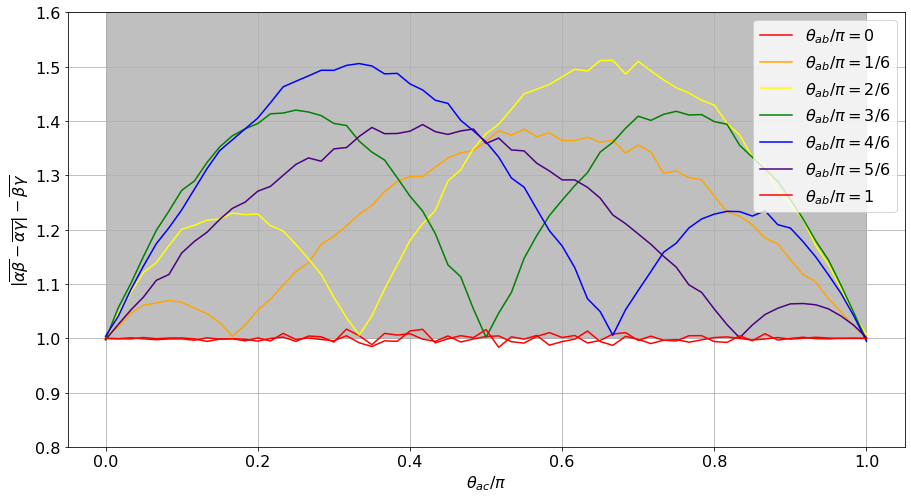

In [29]:
plt.rcParams.update({'font.size': 16})
colors = ["red", "orange", "yellow", "green", "blue", "indigo", "red"]
fig, ax = plt.subplots(figsize=(15, 8))
th = [(i/ac_steps) for i in range(ac_steps+1)]
labels=['$\\theta_{ab}/\pi = 0$'] + ['$\\theta_{ab}/\pi = %d/%d$' % (i_ab, ab_steps) for i_ab in range(1, ab_steps)] + ['$\\theta_{ab}/\pi = 1$']

for i_ab in range(ab_steps+1):
    ax.plot(th, Bell[i_ab][:len(th)], color=colors[i_ab], label=labels[i_ab])

# color the violation band
ax.fill_between(x=th, y1=2, y2=1, color="0.5", alpha=0.5)
ax.set_ylim([0.8, 1.6])
plt.xlabel('$\\theta_{ac} / \pi$')
plt.ylabel('$|\\overline{\\alpha \\beta} - \\overline{\\alpha \\gamma}| - \\overline{\\beta \\gamma}$')
#plt.title('Violation of the Bell inequality')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()
#fig.savefig("simulation_Bell_Qibo.pdf")

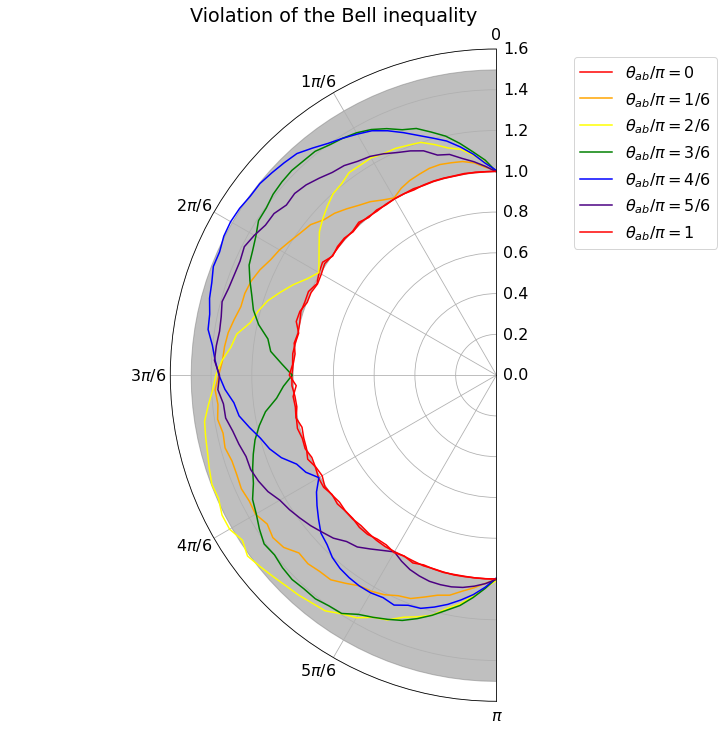

In [25]:
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})
th = [(i*pi/ac_steps) for i in range(ac_steps+1)]

for i_ab in range(ab_steps+1):
    ax.plot(th, Bell[i_ab][:len(th)], color=colors[i_ab], label=labels[i_ab])

# color the violation band
ax.fill_between(x=th, y1=1, y2=1.5, color="0.5", alpha=0.5)

ax.set_xticks([(i*pi/6) for i in range(7)], labels=['0'] + ['$%d\\pi/6$    ' % i for i in range(1, 6)] + ['$\\pi$'])
ax.set_theta_zero_location("N")
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_ylim([0, 1.6])

plt.title('Violation of the Bell inequality')
plt.grid(True)
ax.legend(bbox_to_anchor=(1.1, 1.0))
plt.show()
#fig.savefig("simulation_Bell_Qibo_polar.pdf")